# goal of this is to look at the gateway transport for the season

Compute Total Heat Transport (AW Inflow vs. Local Heat Content)

Q_AW = rhoCp integral over depth (u * T)dz

Compare 2007 vs. 2014:
If Q_AW is much larger in 2007, then inflow dominates deep warming.
If Q_AW is similar, but deep T is different, then PF strength or mixing is the key factor.

Compare mixing 2007 to 2014
If mixing was larger in 2014, weak PF + more mixing cooled deep T
If mixing is larger in 2007, mixing is not why T is warm (this is from AW advection being warmer)

Compare surface heat fluxes between 2007 and 2014:
If Q surf explains warming and cooling trends, sea ice changes matter
If Q surf is weak but deep T is different, sea ice is not the dominant factor in change

What are the potential influences on deep heat:
- AW inflow strength (more heat inflow allows for more heat accumulation)
- polar front strength (stronger traps more heat at depth, weaker allows mixing and deep cooling
- sea ice extent (less sea ice, more surface heat flux)

What are the influences on the polar front:

- stronger AW-ArW contrast (T-S gradients)
- melting limits mixing (weaker front with more sea ice extent)
- wind forcing
- vertical mixing (less mixing, stronger front)

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



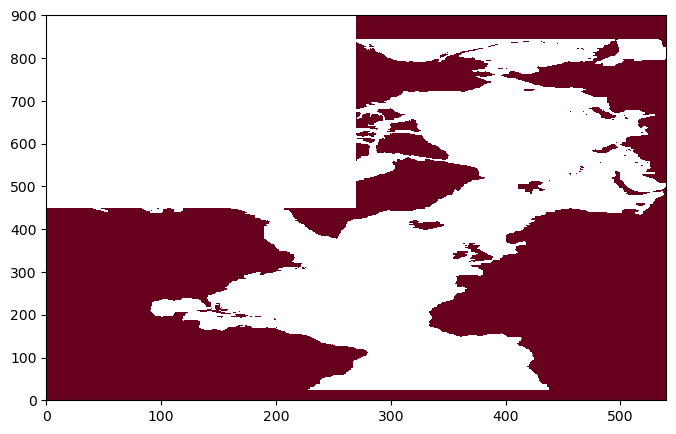

In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

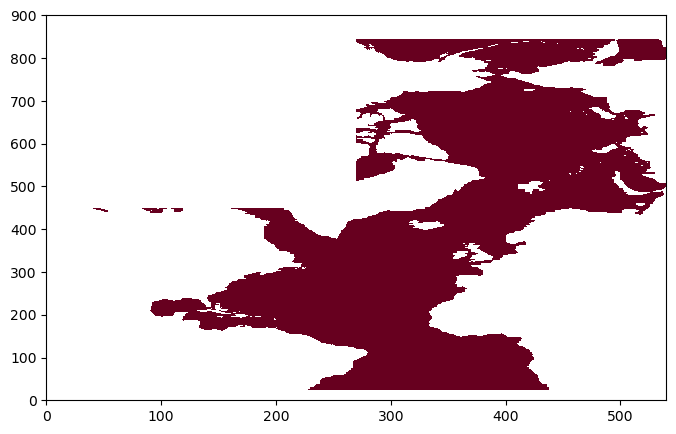

In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [6]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [7]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

# x_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["ix"]-1  #3
# y_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["jy"]-1

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
# test[y_sta_vilkit,x_sta_vilkit] = 4

In [8]:
# plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0])
plt.pcolormesh(test)

plt.xlim(50,100)
plt.ylim(400,600)

(400.0, 600.0)

In [9]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)

In [11]:
# get the theta profile average for this sectino
# get the theta and salt for all years

allTHETA = np.full((4,12,nz,ny,nx),np.nan)
allSALT = np.full((4,12,nz,ny,nx),np.nan)

thetaprofile = np.zeros((nz,4*12))

iy = 0
it = 0
yrs = np.array([2006,2007,2013,2014])
yrs = np.array([2005,2006,2012,2013])  # lead time of 1 year

for year in yrs:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    THETA_all = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALT_all = np.full((len(tsstr),nz,ny,nx),np.nan)

    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    
        THETA_all[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx))
        SALT_all[i,:,:,:] = np.reshape(SALTi,(nz,ny,nx))

        
    # set this in the larger array
    allTHETA[iy,:,:,:,:] = THETA_all
    allSALT[iy,:,:,:,:] = SALT_all

    
    iy += 1

2005
2006
2012
2013


In [12]:
# do a sample for the BSO
# get the distance from coast to coast from DXG and DYG
distance = np.array([])

# get the adv values
for i in range(len(x_bso)):
    thisy = y_bso[i]
    thisx = x_bso[i]
    this_choose = choose_UV_bso[i]

    if this_choose == 'H':
        distance = np.append(distance,(mygrid['DYG'][thisy,thisx]))
    else:
        distance = np.append(distance,(mygrid['DXG'][thisy,thisx]))

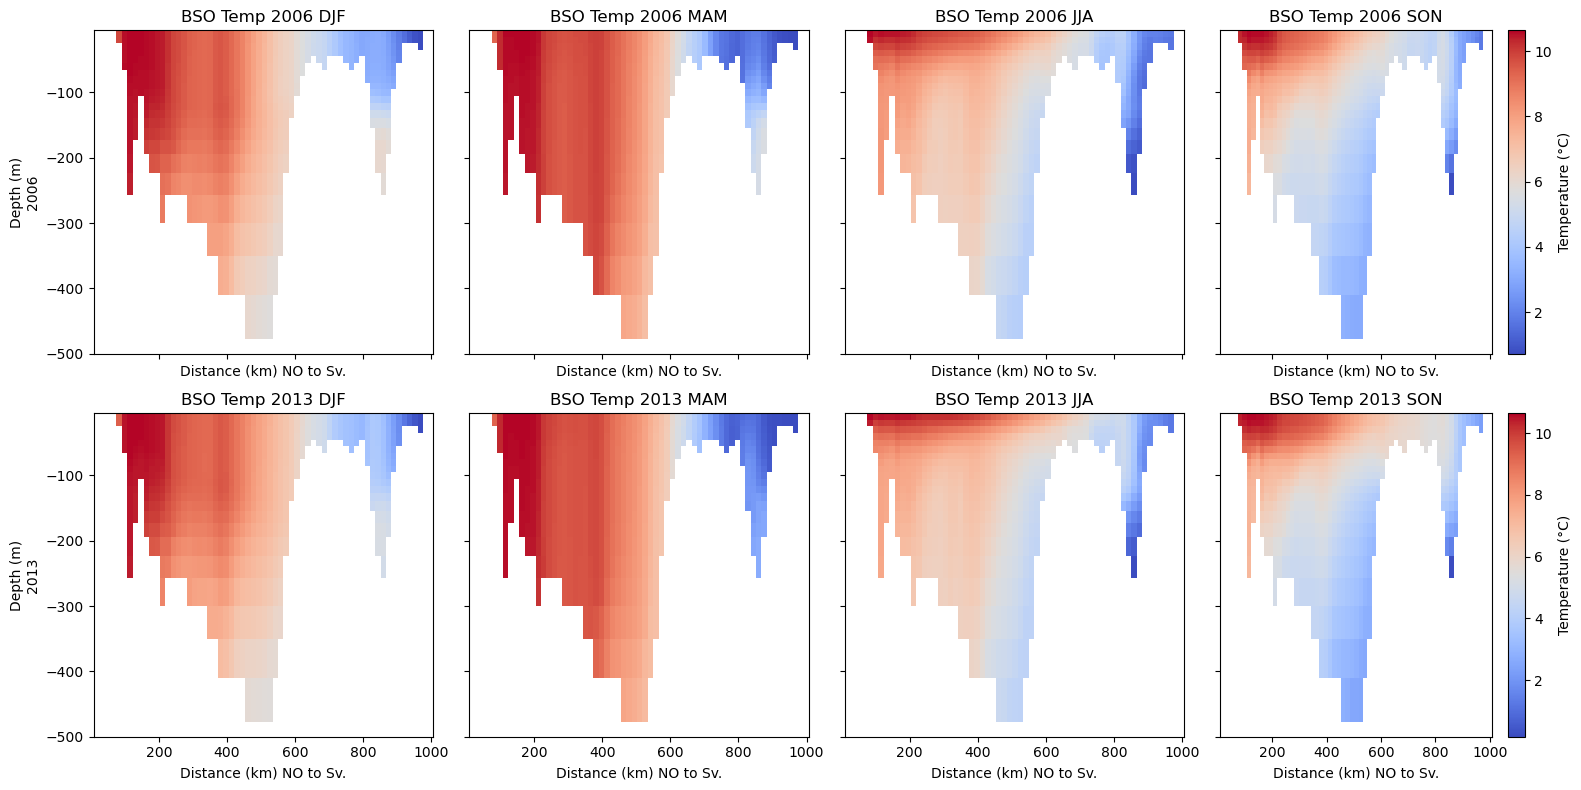

In [13]:
# **Define seasons (with DJF using December from the previous year)**
seasons = {
    "DJF": {"prev_dec": True, "months": [0, 1]},  # December (prev year) + Jan, Feb
    "MAM": {"prev_dec": False, "months": [2, 3, 4]},  # Mar, Apr, May
    "JJA": {"prev_dec": False, "months": [5, 6, 7]},  # Jun, Jul, Aug
    "SON": {"prev_dec": False, "months": [8, 9, 10]}  # Sep, Oct, Nov
}

# **Set distance and depth axes**
x = np.cumsum(distance / 1000)  # Convert to km
y = np.cumsum(-mygrid["DRF"])  # Depth in meters

# **Define the years we are comparing**
# yrs = np.array([2006,2007,2013,2014])
year_pairs = [(2006, 2007), (2013, 2014)]  # (Previous year for DJF, main year)
year_pairs = [(2005, 2006), (2012, 2013)]  # (Previous year for DJF, main year)


# **Create figure and subplots (2 rows: years, 4 columns: seasons)**
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)

for row_idx, (prev_year, main_year) in enumerate(year_pairs):  # Compare 2007 vs. 2014
    for col_idx, (season, config) in enumerate(seasons.items()):
        # Identify indices for selected years
        prev_year_idx = np.where(yrs == prev_year)[0][0]
        main_year_idx = np.where(yrs == main_year)[0][0]

        # **Handle DJF separately**
        if config["prev_dec"]:
            # Get December from the previous year and Jan-Feb from the main year
            theta_dec = allTHETA[prev_year_idx, 11]  # December from previous year
            theta_jf = np.nanmean(allTHETA[main_year_idx, config["months"]], axis=0)  # Jan-Feb from current year
            theta_seasonal = np.nanmean(np.stack([theta_dec, theta_jf]), axis=0)
        else:
            # Get standard seasonal mean
            theta_seasonal = np.nanmean(allTHETA[main_year_idx, config["months"]], axis=0)

        # Extract BSO section
        data = theta_seasonal[:, y_bso, x_bso]  

        # Mask out zeros by converting them to NaN
        data_masked = np.where(data == 0, np.nan, data)

        # **Plot**
        ax = axes[row_idx, col_idx]
        cb = ax.pcolormesh(x, y, data_masked, cmap="coolwarm", shading="auto")
        if col_idx == 0:
            ax.set_ylabel(f"Depth (m)\n{main_year}")

        ax.set_ylim(-500, -5)
        ax.set_xlabel("Distance (km) NO to Sv.")
        ax.set_title(f"BSO Temp {main_year} {season}")

        # Add colorbar only to the rightmost column
        if col_idx == 3:
            cbar = plt.colorbar(cb, ax=ax, location="right")
            cbar.set_label("Temperature (°C)")

# **Save figure**
plt.tight_layout()
plt.savefig("figs/BSO_Temperature_Seasons_2006_2013.png", dpi=300)
plt.show()

In [14]:
# I think we want to create a similar plot for heat transport

# get the theta profile average for this sectino
# get the theta and salt for all years

allADVx_TH = np.full((4,12,nz,ny,nx),np.nan)
allADVy_TH = np.full((4,12,nz,ny,nx),np.nan)
thetaprofile = np.zeros((nz,4*12))

iy = 0
it = 0
# yrs = np.array([2006,2007,2013,2014])
for year in yrs:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    ADVx_TH_all = np.full((len(tsstr),nz,ny,nx),np.nan)
    ADVy_TH_all = np.full((len(tsstr),nz,ny,nx),np.nan)

    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_hflux_set2'
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        varnames = np.array(["ADVx_TH","ADVy_TH"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        ADVx_THi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        ADVy_THi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m

    
        ADVx_TH_all[i,:,:,:] = np.reshape(ADVx_THi,(nz,ny,nx))
        ADVy_TH_all[i,:,:,:] = np.reshape(ADVy_THi,(nz,ny,nx))

        
    # set this in the larger array
    allADVx_TH[iy,:,:,:,:] = ADVx_TH_all
    allADVy_TH[iy,:,:,:,:] = ADVy_TH_all

    
    iy += 1

2005
2006
2012
2013


In [15]:
choose_UV_bso

array(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'H', 'H', 'H', 'V', 'V', 'V', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V'],
      dtype='<U32')

In [16]:
choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

In [17]:
# **Define seasons (with DJF using December from the previous year)**
seasons = {
    "DJF": {"prev_dec": True, "months": [0, 1]},  # December (prev year) + Jan, Feb
    "MAM": {"prev_dec": False, "months": [2, 3, 4]},  # Mar, Apr, May
    "JJA": {"prev_dec": False, "months": [5, 6, 7]},  # Jun, Jul, Aug
    "SON": {"prev_dec": False, "months": [8, 9, 10]}  # Sep, Oct, Nov
}

# **Set distance and depth axes**
x = np.cumsum(distance / 1000)  # Convert to km
y = np.cumsum(-mygrid["DRF"])  # Depth in meters

# **Define the years we are comparing**
# year_pairs = [(2006, 2007), (2013, 2014)]  # (Previous year for DJF, main year)

# **Create figure and subplots (2 rows: years, 4 columns: seasons)**
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)

for row_idx, (prev_year, main_year) in enumerate(year_pairs):  # Compare 2007 vs. 2014
    for col_idx, (season, config) in enumerate(seasons.items()):
        # Identify indices for selected years
        prev_year_idx = np.where(yrs == prev_year)[0][0]
        main_year_idx = np.where(yrs == main_year)[0][0]

        # **Handle DJF separately**
        if config["prev_dec"]:
            # Get December from the previous year and Jan-Feb from the main year
            advx_dec = allADVx_TH[prev_year_idx, 11]  # December from previous year
            advy_dec = allADVy_TH[prev_year_idx, 11]  # December from previous year
            advx_jf = np.nanmean(allADVx_TH[main_year_idx, config["months"]], axis=0)  # Jan-Feb from current year
            advy_jf = np.nanmean(allADVy_TH[main_year_idx, config["months"]], axis=0)  # Jan-Feb from current year

            advx_seasonal = np.nanmean(np.stack([advx_dec, advx_jf]), axis=0)
            advy_seasonal = np.nanmean(np.stack([advy_dec, advy_jf]), axis=0)
        else:
            # Get standard seasonal mean
            advx_seasonal = np.nanmean(allADVx_TH[main_year_idx, config["months"]], axis=0)
            advy_seasonal = np.nanmean(allADVy_TH[main_year_idx, config["months"]], axis=0)

        # **Apply selection logic**
        adv_selected = np.where(choose_UV_bso3d == "H", advx_seasonal, -advy_seasonal)

        # **Convert to Heat Transport (W)**
        heat_transport = myparms['rcp'] * adv_selected  # m^3.degC/s * J/m^3.degC = Watts (J/s)

        # Extract BSO section
        data = heat_transport[:, y_bso, x_bso]  

        # Mask out zeros by converting them to NaN
        data_masked = np.where(data == 0, np.nan, data)

        # **Plot**
        ax = axes[row_idx, col_idx]
        cb = ax.pcolormesh(x, y, data_masked, cmap="seismic", shading="auto", vmin=-1e12, vmax=1e12)
        if col_idx == 0:
            ax.set_ylabel(f"Depth (m)\n{main_year}")

        ax.set_ylim(-500, -5)
        ax.set_xlabel("Distance (km) NO to Sv.")
        ax.set_title(f"BSO Heat Transport {main_year} {season}")

        # Add colorbar only to the rightmost column
        if col_idx == 3:
            cbar = plt.colorbar(cb, ax=ax, location="right")
            cbar.set_label("Heat Transport (W) (+ into sea)")

# **Save figure**
plt.tight_layout()
plt.savefig("figs/BSO_Heat_Transport_Seasons_2006_2013.png", dpi=300)
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# **Define seasons (with DJF using December from the previous year)**
seasons = {
    "DJF": {"prev_dec": True, "months": [0, 1]},  # December (prev year) + Jan, Feb
    "MAM": {"prev_dec": False, "months": [2, 3, 4]},  # Mar, Apr, May
    "JJA": {"prev_dec": False, "months": [5, 6, 7]},  # Jun, Jul, Aug
    "SON": {"prev_dec": False, "months": [8, 9, 10]}  # Sep, Oct, Nov
}

# **Set distance and depth axes**
x = np.cumsum(distance / 1000)  # Convert to km
y = np.cumsum(-mygrid["DRF"])  # Depth in meters

# **Define the years we are comparing**
prev_year, main_year = 2007, 2014  # Difference: 2014 - 2007
prev_year, main_year = 2006, 2013  # Difference: 2014 - 2007

prev_year_idx = np.where(yrs == prev_year)[0][0]
main_year_idx = np.where(yrs == main_year)[0][0]

# **Create figure and subplots (2 rows: differences for temperature & heat transport, 4 columns: seasons)**
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)

for col_idx, (season, config) in enumerate(seasons.items()):
    # **Handle DJF separately**
    if config["prev_dec"]:
        # Get December from the previous year and Jan-Feb from the main year
        theta_dec_prev = allTHETA[prev_year_idx - 1, 11]  # December from previous year
        theta_jf_prev = np.nanmean(allTHETA[prev_year_idx, config["months"]], axis=0)
        theta_seasonal_prev = np.nanmean(np.stack([theta_dec_prev, theta_jf_prev]), axis=0)

        theta_dec_main = allTHETA[main_year_idx - 1, 11]  # December from previous year
        theta_jf_main = np.nanmean(allTHETA[main_year_idx, config["months"]], axis=0)
        theta_seasonal_main = np.nanmean(np.stack([theta_dec_main, theta_jf_main]), axis=0)
    else:
        # Get standard seasonal mean
        theta_seasonal_prev = np.nanmean(allTHETA[prev_year_idx, config["months"]], axis=0)
        theta_seasonal_main = np.nanmean(allTHETA[main_year_idx, config["months"]], axis=0)

    # **Compute temperature difference: 2014 - 2007**
    theta_diff = theta_seasonal_main - theta_seasonal_prev
    theta_data = theta_diff[:, y_bso, x_bso]
    theta_masked = np.where(theta_data == 0, np.nan, theta_data)

    # **Plot temperature difference**
    ax = axes[0, col_idx]
    cb = ax.pcolormesh(x, y, theta_masked, cmap="coolwarm", shading="auto", vmin=-2, vmax=2)
    if col_idx == 0:
        ax.set_ylabel("Depth (m)\nΔTemperature (°C)")
    ax.set_ylim(-500, -5)
    ax.set_xlabel("Distance (km) NO to Sv.")
    ax.set_title(f"ΔTemp {main_year} - {prev_year} ({season})")

    # Add colorbar only to the rightmost column
    if col_idx == 3:
        cbar = plt.colorbar(cb, ax=ax, location="right")
        cbar.set_label("ΔTemperature (°C)")

    # **Handle DJF separately for Heat Transport**
    if config["prev_dec"]:
        advx_dec_prev = allADVx_TH[prev_year_idx - 1, 11]  # December from previous year
        advy_dec_prev = allADVy_TH[prev_year_idx - 1, 11]  # December from previous year
        advx_jf_prev = np.nanmean(allADVx_TH[prev_year_idx, config["months"]], axis=0)
        advy_jf_prev = np.nanmean(allADVy_TH[prev_year_idx, config["months"]], axis=0)
        advx_seasonal_prev = np.nanmean(np.stack([advx_dec_prev, advx_jf_prev]), axis=0)
        advy_seasonal_prev = np.nanmean(np.stack([advy_dec_prev, advy_jf_prev]), axis=0)

        advx_dec_main = allADVx_TH[main_year_idx - 1, 11]  # December from previous year
        advy_dec_main = allADVy_TH[main_year_idx - 1, 11]  # December from previous year
        advx_jf_main = np.nanmean(allADVx_TH[main_year_idx, config["months"]], axis=0)
        advy_jf_main = np.nanmean(allADVy_TH[main_year_idx, config["months"]], axis=0)
        advx_seasonal_main = np.nanmean(np.stack([advx_dec_main, advx_jf_main]), axis=0)
        advy_seasonal_main = np.nanmean(np.stack([advy_dec_main, advy_jf_main]), axis=0)
    else:
        advx_seasonal_prev = np.nanmean(allADVx_TH[prev_year_idx, config["months"]], axis=0)
        advy_seasonal_prev = np.nanmean(allADVy_TH[prev_year_idx, config["months"]], axis=0)
        advx_seasonal_main = np.nanmean(allADVx_TH[main_year_idx, config["months"]], axis=0)
        advy_seasonal_main = np.nanmean(allADVy_TH[main_year_idx, config["months"]], axis=0)

    # **Apply selection logic using choose_UV_bso**
    adv_selected_prev = np.where(choose_UV_bso3d == "H", advx_seasonal_prev, -advy_seasonal_prev)
    adv_selected_main = np.where(choose_UV_bso3d == "H", advx_seasonal_main, -advy_seasonal_main)

    # **Convert to Heat Transport (W)**
    heat_transport_prev = myparms["rcp"] * adv_selected_prev # J/degC/m^3 * degC/m^3/s = J/s = W
    heat_transport_main = myparms["rcp"] * adv_selected_main

    # **Compute Heat Transport difference: 2014 - 2007**
    heat_transport_diff = heat_transport_main - heat_transport_prev
    heat_transport_data = heat_transport_diff[:, y_bso, x_bso]
    heat_transport_masked = np.where(heat_transport_data == 0, np.nan, heat_transport_data)

    # **Plot heat transport difference**
    ax = axes[1, col_idx]
    cb = ax.pcolormesh(x, y, heat_transport_masked, cmap="seismic", shading="auto", vmin=-1e11, vmax=1e11)
    if col_idx == 0:
        ax.set_ylabel("Depth (m)\nΔHeat Transport (W)")
    ax.set_ylim(-500, -5)
    ax.set_xlabel("Distance (km) NO to Sv.")
    ax.set_title(f"ΔHeat Transport {main_year} - {prev_year} ({season})")

    # Add colorbar only to the rightmost column
    if col_idx == 3:
        cbar = plt.colorbar(cb, ax=ax, location="right")
        cbar.set_label("ΔHeat Transport (W)")

# **Save figure**
plt.tight_layout()
plt.savefig("figs/BSO_Difference_Temperature_HeatTransport_2013-2006.png", dpi=300)
plt.show()

# let's work on some animation of this, do the temperature profile and the anomaly

In [17]:
choose_UV_bso 
# choose_UV_sfj 
# choose_UV_fjnz 

array(['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'H', 'H', 'H', 'V', 'V', 'V', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'V'],
      dtype='<U32')

In [18]:
allyears

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017])

In [19]:
import numpy as np
import os

# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(test == label) for gate, label in zip(gate_labels, [1, 2, 3])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        for depth in range(nz):
            theta_timeseries[gate][iy, depth, :] = np.nanmean(THETA_all[:, depth, y_idx, x_idx], axis=0)
            salt_timeseries[gate][iy, depth, :] = np.nanmean(SALT_all[:, depth, y_idx, x_idx], axis=0)

    iy += 1  # Move to the next year


Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [20]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [52]:
# Define distance along the gate (assuming uniform spacing)
x_gate = {gate: np.arange(theta_timeseries[gate].shape[2]) for gate in gate_labels}  # Distance index
x_labels = {
    "BSO": "km from Norway to SP",
    "SFJ": "km from SFJ to SP",
    "FJNZ": "km from NZ to SFJ"
}

# Loop through each year and create a 2x3 plot for temperature and salinity at each gate
for year_idx, year in enumerate(allyears):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
    print(year)

    for gate_idx, gate in enumerate(gate_labels):
        # Extract annual averages
        theta_data = theta_timeseries[gate][year_idx]
        salt_data = salt_timeseries[gate][year_idx]

        # Mask zeros to NaN for better visualization
        theta_masked = np.where(theta_data == 0, np.nan, theta_data)
        salt_masked = np.where(salt_data == 0, np.nan, salt_data)

        # Generate x and y coordinates
        x_vals = gate_distances[gate]  # Distance along the gate in km
        x_min, x_max = x_vals.min(), x_vals.max()
        y_vals = np.cumsum(mygrid['DRF'])


        print('plotting' + gate)

        # Plot temperature
        ax1 = axes[0, gate_idx]
        im1 = ax1.imshow(theta_masked, cmap="coolwarm", aspect="auto",
                         extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()],vmin=-2,vmax=4)
        ax1.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax1.set_title(f"{gate} Temp {year}")
        if gate_idx == 0:
            ax1.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical")
            cbar1.set_label("Temperature (°C)")

        # Plot salinity
        ax2 = axes[1, gate_idx]
        im2 = ax2.imshow(salt_masked, cmap="viridis", aspect="auto",
                         extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()],vmin=33,vmax=35)
        ax2.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax2.set_title(f"{gate} Salinity {year}")
        ax2.set_xlabel(x_labels[gate])  # Set custom x-axis label
        if gate_idx == 0:
            ax2.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar2 = fig.colorbar(im2, ax=ax2, orientation="vertical")
            cbar2.set_label("Salinity (PSU)")

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(f"figs/gate_temp/Theta_Salt_Gates_{year}.png", dpi=300)
    plt.close()


2003
plottingBSO
plottingSFJ
plottingFJNZ
2004
plottingBSO
plottingSFJ
plottingFJNZ
2005
plottingBSO
plottingSFJ
plottingFJNZ
2006
plottingBSO
plottingSFJ
plottingFJNZ
2007
plottingBSO
plottingSFJ
plottingFJNZ
2008
plottingBSO
plottingSFJ
plottingFJNZ
2009
plottingBSO
plottingSFJ
plottingFJNZ
2010
plottingBSO
plottingSFJ
plottingFJNZ
2011
plottingBSO
plottingSFJ
plottingFJNZ
2012
plottingBSO
plottingSFJ
plottingFJNZ
2013
plottingBSO
plottingSFJ
plottingFJNZ
2014
plottingBSO
plottingSFJ
plottingFJNZ
2015
plottingBSO
plottingSFJ
plottingFJNZ
2016
plottingBSO
plottingSFJ
plottingFJNZ
2017
plottingBSO
plottingSFJ
plottingFJNZ


In [50]:
# also plot the anomalies for these based on the first 5 years
import numpy as np
import matplotlib.pyplot as plt

# Define distance along the gate (assuming uniform spacing)
x_labels = {
    "BSO": "km from Norway to SP (increasing toward SP)",
    "SFJ": "km from SFJ to SP (increasing toward SP)",
    "FJNZ": "km from NZ to SFJ (increasing toward SFJ)"
}

# Compute the mean over the first 5 years for each gate
theta_baseline = {gate: np.nanmean(theta_timeseries[gate][:5], axis=0) for gate in gate_labels}
salt_baseline = {gate: np.nanmean(salt_timeseries[gate][:5], axis=0) for gate in gate_labels}

# Loop through the last 10 years and create a 2x3 plot for anomaly temperature and salinity at each gate
for year_idx in range(-11, 0):  # Last 10 years
    year = allyears[year_idx]  # Extract corresponding year
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
    print(f"Plotting anomaly for {year}")

    for gate_idx, gate in enumerate(gate_labels):
        # Compute anomaly (last 10 years - first 5 years mean)
        theta_anomaly = theta_timeseries[gate][year_idx] - theta_baseline[gate]
        salt_anomaly = salt_timeseries[gate][year_idx] - salt_baseline[gate]

        # Mask zeros to NaN for better visualization
        theta_masked = np.where(theta_anomaly == 0, np.nan, theta_anomaly)
        salt_masked = np.where(salt_anomaly == 0, np.nan, salt_anomaly)

        # Generate x and y coordinates
        x_vals = gate_distances[gate]  # Distance along the gate in km
        x_min, x_max = x_vals.min(), x_vals.max()
        y_vals = np.cumsum(mygrid['DRF'])

        print(f"Plotting {gate} anomaly for {year}")

        # Plot temperature anomaly
        ax1 = axes[0, gate_idx]
        im1 = ax1.imshow(theta_masked, cmap="RdBu_r", aspect="auto",
                         extent=[x_min, x_max, y_vals.max(), y_vals.min()], vmin=-2, vmax=2)
        ax1.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax1.set_title(f"{gate} Temp Anomaly {year}")
        if gate_idx == 0:
            ax1.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical")
            cbar1.set_label("Temperature Anomaly (°C)")

        # Plot salinity anomaly
        ax2 = axes[1, gate_idx]
        im2 = ax2.imshow(salt_masked, cmap="BrBG", aspect="auto",
                         extent=[x_min, x_max, y_vals.max(), y_vals.min()], vmin=-0.6, vmax=0.6)
        ax2.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax2.set_title(f"{gate} Salinity Anomaly {year}")
        ax2.set_xlabel(x_labels[gate])  # Set custom x-axis label
        if gate_idx == 0:
            ax2.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar2 = fig.colorbar(im2, ax=ax2, orientation="vertical")
            cbar2.set_label("Salinity Anomaly (PSU)")

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(f"figs/gate_anomaly/Theta_Salt_Gates_Anomaly_{year}.png", dpi=300)
    plt.close()

Plotting anomaly for 2007
Plotting BSO anomaly for 2007
Plotting SFJ anomaly for 2007
Plotting FJNZ anomaly for 2007
Plotting anomaly for 2008
Plotting BSO anomaly for 2008
Plotting SFJ anomaly for 2008
Plotting FJNZ anomaly for 2008
Plotting anomaly for 2009
Plotting BSO anomaly for 2009
Plotting SFJ anomaly for 2009
Plotting FJNZ anomaly for 2009
Plotting anomaly for 2010
Plotting BSO anomaly for 2010
Plotting SFJ anomaly for 2010
Plotting FJNZ anomaly for 2010
Plotting anomaly for 2011
Plotting BSO anomaly for 2011
Plotting SFJ anomaly for 2011
Plotting FJNZ anomaly for 2011
Plotting anomaly for 2012
Plotting BSO anomaly for 2012
Plotting SFJ anomaly for 2012
Plotting FJNZ anomaly for 2012
Plotting anomaly for 2013
Plotting BSO anomaly for 2013
Plotting SFJ anomaly for 2013
Plotting FJNZ anomaly for 2013
Plotting anomaly for 2014
Plotting BSO anomaly for 2014
Plotting SFJ anomaly for 2014
Plotting FJNZ anomaly for 2014
Plotting anomaly for 2015
Plotting BSO anomaly for 2015
Plotting

# now plot the heat transport and the heat transport anomalies similarly

In [47]:
# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(test == label) for gate, label in zip(gate_labels, [1, 2, 3])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d}

# Initialize dictionary to store heat transport for each gate
heat_transport_timeseries = {
    gate: np.full((num_years, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    ADVx_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]

        read = [int(tsstr[i])]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])

        ADVx_TH_all[i, :, :, :] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i, :, :, :] = np.reshape(ADVy_THi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            advx_seasonal = myparms["rcp"] * np.nanmean(ADVx_TH_all[:, depth, y_idx, x_idx], axis=0) # annual averaging
            advy_seasonal = myparms["rcp"] * np.nanmean(ADVy_TH_all[:, depth, y_idx, x_idx], axis=0) # annual averaging
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_seasonal, -advy_seasonal)
            elif gate == "SFJ":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)
            else:
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)

            heat_transport_timeseries[gate][iy, depth, :] = adv_selected


    iy += 1  # Move to the next year


Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [54]:
# Define distance along the gate (assuming uniform spacing)
x_labels = {
    "BSO": "km from Norway to SP (increasing toward SP)",
    "SFJ": "km from SFJ to SP (increasing toward SP)",
    "FJNZ": "km from NZ to SFJ (increasing toward SFJ)"
}

# Compute the mean over the first 5 years for each gate
heat_transport_baseline = {gate: np.nanmean(heat_transport_timeseries[gate][:5], axis=0) for gate in gate_labels}

# Loop through the last 10 years and create a 2x3 plot for heat transport and its anomaly
for year_idx in range(-11, 0):  # Last 10 years
    year = allyears[year_idx]  # Extract corresponding year
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
    print(f"Plotting heat transport and anomaly for {year}")

    for gate_idx, gate in enumerate(gate_labels):
        # Compute anomaly (last 10 years - first 5 years mean)
        heat_anomaly = heat_transport_timeseries[gate][year_idx] - heat_transport_baseline[gate]

        # Mask zeros to NaN for better visualization
        heat_masked = np.where(heat_transport_timeseries[gate][year_idx] == 0, np.nan, heat_transport_timeseries[gate][year_idx])
        anomaly_masked = np.where(heat_anomaly == 0, np.nan, heat_anomaly)

        # Generate x and y coordinates
        x_vals = gate_distances[gate]  # Distance along the gate in km
        x_min, x_max = x_vals.min(), x_vals.max()
        y_vals = np.cumsum(mygrid['DRF'])

        print(f"Plotting {gate} heat transport and anomaly for {year}")

        # **Plot advective heat transport**
        ax1 = axes[0, gate_idx]
        im1 = ax1.imshow(heat_masked, cmap="coolwarm", aspect="auto",
                         extent=[x_min, x_max, y_vals.max(), y_vals.min()], vmin=-1e11, vmax=1e11)
        ax1.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax1.set_title(f"{gate} Heat Transport {year}")
        if gate_idx == 0:
            ax1.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical")
            cbar1.set_label("Heat Transport (W) (+ into sea)")

        # **Plot anomaly**
        ax2 = axes[1, gate_idx]
        im2 = ax2.imshow(anomaly_masked, cmap="RdBu_r", aspect="auto",
                         extent=[x_min, x_max, y_vals.max(), y_vals.min()], vmin=-5e10, vmax=5e10)
        ax2.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax2.set_title(f"{gate} Heat Transport Anomaly {year}")
        ax2.set_xlabel(x_labels[gate])  # Set custom x-axis label
        if gate_idx == 0:
            ax2.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar2 = fig.colorbar(im2, ax=ax2, orientation="vertical")
            cbar2.set_label("Heat Transport Anomaly (W)")

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(f"figs/gate_heat_transport/Heat_Transport_Gates_{year}.png", dpi=300)
    plt.close()


Plotting heat transport and anomaly for 2007
Plotting BSO heat transport and anomaly for 2007
Plotting SFJ heat transport and anomaly for 2007
Plotting FJNZ heat transport and anomaly for 2007
Plotting heat transport and anomaly for 2008
Plotting BSO heat transport and anomaly for 2008
Plotting SFJ heat transport and anomaly for 2008
Plotting FJNZ heat transport and anomaly for 2008
Plotting heat transport and anomaly for 2009
Plotting BSO heat transport and anomaly for 2009
Plotting SFJ heat transport and anomaly for 2009
Plotting FJNZ heat transport and anomaly for 2009
Plotting heat transport and anomaly for 2010
Plotting BSO heat transport and anomaly for 2010
Plotting SFJ heat transport and anomaly for 2010
Plotting FJNZ heat transport and anomaly for 2010
Plotting heat transport and anomaly for 2011
Plotting BSO heat transport and anomaly for 2011
Plotting SFJ heat transport and anomaly for 2011
Plotting FJNZ heat transport and anomaly for 2011
Plotting heat transport and anomaly

In [58]:
heat_transport_timeseries['BSO'].shape

(15, 50, 63)

In [64]:
# find a year most similar to 2007 for heat transport

closest = 1e20
bso_2007 = heat_transport_timeseries['BSO'][4]
for year in range(len(allyears)):
    print(allyears[year])
    a = (np.nansum(heat_transport_timeseries['BSO'][year] - bso_2007))
    if np.abs(a) < np.abs(closest):
        if year != 4:
            closest = a
            print(year)

2003
0
2004
1
2005
2
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
12
2016
2017


In [65]:
closest

-2120908226432.6758

In [66]:
# compare 2007 to 2015